**该notebook以titanic数据为例，梳理了一些ml建模常用的操作，包括如下一些内容：**   

1. 理解数据并可视化分析(pandas,seaborn)  

2. 数据清洗：NaN的不同填充方法、categorical 变量的处理、数据归一化操作(z-score,min-max,normalize,log,boxcox等)  

3. 模型选择(方差-偏差、过拟合-欠拟合)  

4. 优化，包括：  

    4.1 特征增强
        4.1.1 特征优化：根据背景知识造特征、聚类算法构建新特征、长尾数据的log变换、boxcox、cdf、pdf变换；构建组合特征，自动构建组合特征(gbdt+lr)；构建交互式特征；  

        4.1.2 特征选择：基于统计方法的方差、相关性、gini、mi、chi2选择等，基于模型的迭代消除法等；  

        4.1.3 特征变换：pca、lda、lle(局部线性嵌入)、ae（自编码）等  

    4.2 数据增强：半监督学习、过采样、根据数据特征造新数据  
    
    4.3 模型增强：
        4.3.1 超参优化：随机搜索、网格搜索、贝叶斯优化
        4.3.2 集成学习：stacking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import random
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.feature_selection import SelectFromModel,VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

导入数据：

Survived:0代表死亡，1代表存活

Pclass:乘客所持票类

Name:乘客姓名

Sex:乘客性别

Age:乘客年龄

SibSp:乘客兄弟姐妹/配偶的个数

Parch:乘客父母/孩子的个数

Ticket:票号

Fare:乘客所持票的价格

Cabin:乘客所在船舱

Embarked:乘客登船港口:S、C、Q

In [2]:
train_df=pd.read_csv('./titanic/train.csv')
test_df=pd.read_csv('./titanic/test.csv')

### 一.理解数据

In [3]:
#查看shape
'训练集：',train_df.shape,'测试集',test_df.shape

('训练集：', (891, 12), '测试集', (418, 11))

In [4]:
#查看数据前几行
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


测试集相对于训练集少了Survived，即任务目标，为了方便后续的各种处理，这里将数据合并，并切分为features部分以及labels部分

In [6]:
labels=train_df['Survived']
origin_features_df=pd.concat([train_df.drop(columns=['Survived']),test_df]).reset_index(drop=True)
features_df=copy.deepcopy(origin_features_df)

In [7]:
features_df.shape

(1309, 11)

In [8]:
features_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
labels.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [10]:
#查看数据条数、每个特征的缺失值个数、特征类型
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


### 1.1特征分类

表现\功能 | 离散型特征 |  数值型特征  
:- | :-: | -:
int,float | PassengerId,**Pclass** | Age,**Pclass**,SibSp,Parch,Fare 
str | Name,Sex,Ticket,Cabin,Embarked |  

从功能上我们可以简单把数据分为两类，一类是离散型特征、一类是数值型特征：  

（1）数值型特征：对**“比较大小”**有意义的特征，比如“高、中、低”，“优秀、良好、一般、差”等这一类特征可以看做数值型特征

（2）离散型特征：PassengerId虽然表现为int，但对其比较大小并无实际意义

In [11]:
#进一步，查看int,float特征的分布
features_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [12]:
#对于object类型特征，也可以使用describe查看最频繁的那一项,以及总的有多少项
features_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [13]:
#通过value_counts查看靠前的项目
features_df['Cabin'].value_counts().head(5)

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
D                  4
F33                4
Name: Cabin, dtype: int64

### 1.2可视化

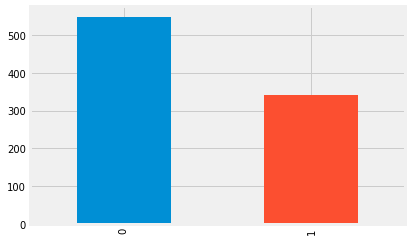

In [14]:
#条形图，存活分布
labels.value_counts().plot(kind='bar')

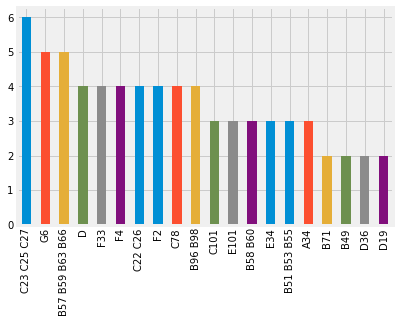

In [15]:
#条形图：查看Cabin的分布
features_df['Cabin'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')

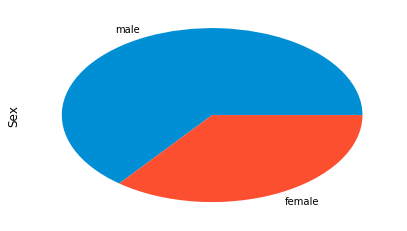

In [16]:
#饼图，查看性别分布
features_df['Sex'].value_counts().sort_values(ascending=False).plot(kind='pie')

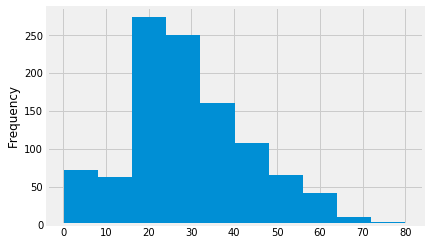

In [17]:
#直方图，查看年龄分布
features_df['Age'].plot(kind='hist')#注意：有别于条形图，这里会将连续值“分箱”

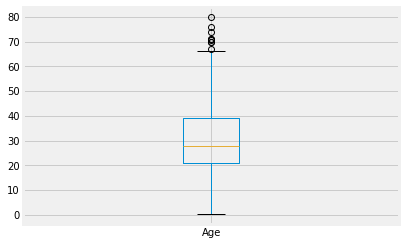

In [18]:
#箱线图，查看年龄分布
features_df['Age'].plot(kind='box')#可见有绝大部分是20-40岁的年轻人

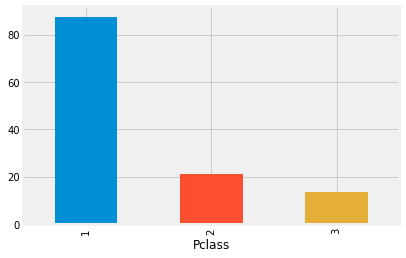

In [19]:
#条形图：查看票价与票类的关系
features_df.groupby('Pclass')['Fare'].mean().plot(kind='bar')#Pclass 1,2,3分别表示头等舱、一等舱、二等舱

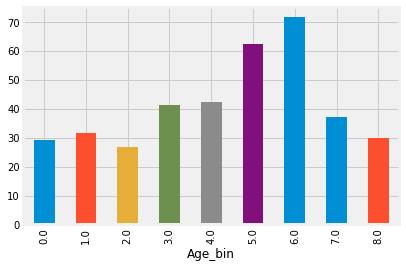

In [20]:
#将年龄分成1-10的10个阶段，并统计对应票价
def age_bin(x):
    try:
        return int(x/10)
    except:
        None
features_df['Age_bin']=features_df['Age'].apply(age_bin)
features_df.groupby('Age_bin')['Fare'].mean().plot(kind='bar')

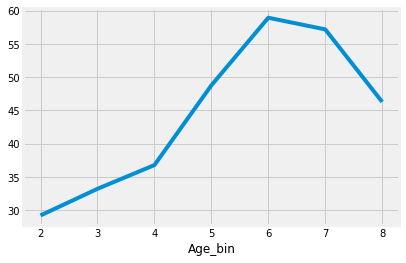

In [21]:
#平滑处理
features_df.groupby('Age_bin')['Fare'].mean().rolling(3).mean().plot(kind='line')#注意:前rolling_num-1项会为None

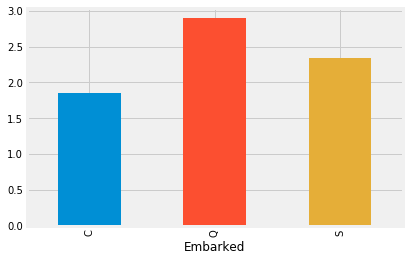

In [22]:
#查看各登船港口与票类的关系
features_df.groupby('Embarked')['Pclass'].mean().plot.bar()

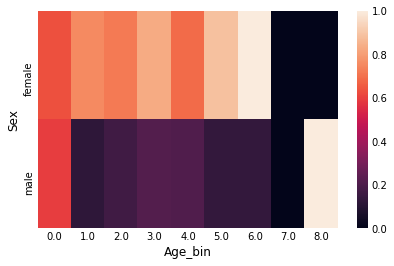

In [23]:
#探索不同性别，不同年龄段的存活率
show_df=features_df[:891]
show_df['Survived']=labels
show_df=show_df.groupby(['Sex','Age_bin'])['Survived'].mean().reset_index().pivot(index='Sex',columns='Age_bin',values='Survived').reset_index()
show_df=show_df.where(show_df.notnull(),0)
show_df.set_index('Sex',inplace=True,drop=True)
sns.heatmap(show_df)

**注意float.nan无法通过fillna填充**  

可以发现婴儿和女性的存活率更高

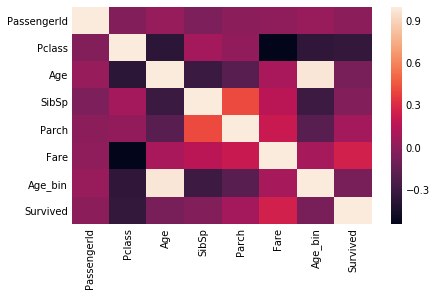

In [24]:
#热图：探索不同特征之间的相关系数
show_df=features_df[:891]
show_df['Survived']=labels
sns.heatmap(show_df.corr())

可以发现是否存活与Fare/票价的正相关性最强，与Pclass负相关性最强

### 二.清洗特征
大概知道了各特征的类型以及缺失值情况后，我们就可以对数据进行清洗，将其转换成int/float数据类型

#### 2.1 None值填充
（1）删除...dropna...(不建议)    
（2）暴力填充fillna一个确定的值  
（3）均值、中位数、众数项填充  
（4）依赖性填充  
    4.1）基于时间的插值；  
    4.2）建模预测...

In [25]:
#首先查看缺失项
features_df.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Age_bin         263
dtype: int64

In [26]:
del features_df['Age_bin']

In [27]:
#为Cabin直接填充一个定值
features_df['Cabin'].fillna('missing',inplace=True)

In [28]:
#为Embarked填充众数项
features_df['Embarked'].fillna(features_df['Embarked'].mode()[0],inplace=True)

In [29]:
#Age与Pclass具有比较强的相关性，利用Age所属Pclass组的均值对其缺失值进行填充
features_df.groupby('Pclass')['Age'].mean().reset_index()

,Pclass,Age
0,1,39.159930
1,2,29.506705
2,3,24.816367


In [30]:
def fill_age(pclass,age):
    if np.isnan(age):#注意：如果当前列为float/int类型，当前列中的None会被强制转为float的nan类型
        if pclass==1:
            return 39.159930
        elif pclass==2:
            return 29.506705
        else:
            return 24.816367
    else:
        return age
features_df['Age']=features_df.apply(lambda row:fill_age(row['Pclass'],row['Age']),axis=1)

In [31]:
features_df['Fare'].fillna(features_df['Fare'].mean(),inplace=True)

In [32]:
#检查一下
features_df.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

也可以多种填充策略组合，比如先依赖于相关性高的进行填充，然后利用整体的均值/中位数等填充，然后fillna一个确定的值等，另外sklearn.preprocessing.Imputer也可方便进行均值、中位数、众数填充  

#### 注意：
**
（1）这里没有那一种填充方法是“绝对”的好，要与后续建模中具体使用的模型结合起来，均值类型的填充也许对决策树一类的算法比较友好，fillna(0)也许对lr/神经网络一类的算法比较友好；  
（2）切记在填充的时候不要依赖到y标签，假如Age与Survived的相关性比较强，如果Age依赖于Survived的分组均值进行填充...想想会发生什么....真正在预测的时候我们不知道Survived真实取值，所以压根没法填充...  
（3）另外这里使用整体数据的均值/中位数进行填充涉嫌“作弊”，因为利用到了测试集部分，更正确的做法是利用训练集的信息去对训练集合测试集进行填充，但一般在样本量很大的情况下，两者均值/中位数....相差不大，所以...
**

In [33]:
features_df['Age'].mean()

29.348219164247467

In [34]:
features_df[:891]['Age'].mean()

29.269997269360225

In [35]:
#目前的情况如下
features_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,missing,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,missing,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,missing,S


#### 2.2 类别特征数值化
我们还有5列类别特征，可以将他们分为两类：  
（1）低数量类别特征/low-cardinality categorical attributes：Sex,Embarked  
（2）高数量类别特征/high-cardinality categorical attributes:Name,Ticket,Cabin

我们一个一个看....  

Sex:明显的离散型特征，可以采用ont-hot编码，由于只有两个可取变量，也可以直接编码0/1  
Embarked:明显的离散型特征，可采用one-hot编码  
Name:可以再深入挖掘的一个特征，比如通过名字判断是否结婚  
Ticket:看不出明显的规律，删掉  
Cabin:这里先简单的采用TargetEncoder,一种Smothing的方式，计算y的占比；后面可以扩展特征，比如同一船舱：是否包含中年男性/是否包含小孩....，如果当前乘客为小孩，而他同行的船舱中有中年男性，那存活的可能性更高? 这里，，，先删掉    

这里推荐category_encoders,有多种对离散特征encoding的方式  
pip install category_encoders  
更多：http://contrib.scikit-learn.org/categorical-encoding/  

In [36]:
import category_encoders as ce
del features_df['Name']
del features_df['Ticket']
onehot_encoder = ce.OneHotEncoder(cols=['Embarked']).fit(features_df)
features_df=onehot_encoder.transform(features_df)

ordinay_encoder = ce.OrdinalEncoder(cols=['Sex']).fit(features_df)
features_df=ordinay_encoder.transform(features_df)

#这里我就偷懒了....
target_encoder = ce.TargetEncoder(cols=['Cabin']).fit(features_df[:891],labels)
features_df=target_encoder.transform(features_df)

In [37]:
features_df['Sex']=features_df['Sex']-1

In [38]:
features_df.head(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3
0,1,3,0,22.0,1,0,7.2500,0.299854,1,0,0
1,2,1,1,38.0,1,0,71.2833,0.383838,0,1,0
2,3,3,1,26.0,0,0,7.9250,0.299854,1,0,0
3,4,1,1,35.0,1,0,53.1000,0.468759,1,0,0
4,5,3,0,35.0,0,0,8.0500,0.299854,1,0,0


In [39]:
#这里PassengerId直接删掉
del features_df['PassengerId']

#### 2.3数据标准化
数据是否需要标准化取决于后面的训练模型，一般来说，数据归一化有如下的一些好处：  
（1）保持量纲的统一；  
（2）梯度下降更稳定；

它对常见算法的影响：  
（1）knn,kmeans：欧氏距离...  
（2）lr,svm,nn：梯度下降...  
（3）pca：偏向于值较大的列  

标准化的方法一般有以下几种：  
（1）z-score：$z=(x-u)/\sigma$  
（2）min-max：$m=(x-x_{min})/(x_{max}-x_{min})$  
（3）行归一化：$\sqrt{(x_1^2+x_2^2+\cdots+x_n^2)}=1,这里x_1,x_2,...,x_n表示每行特征$；  
其他的标准化方法：  
（1）log/boxcox归一化：对长尾分布数据比较有用，可以拉伸头部，压缩尾部

更多：https://www.jianshu.com/p/fa73a07cd750

In [40]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
#z-score归一化
titanic_z_score_df=pd.DataFrame(StandardScaler().fit_transform(features_df),columns=features_df.columns)
#min-max归一化
titanic_min_max_df=pd.DataFrame(MinMaxScaler().fit_transform(features_df),columns=features_df.columns)
#行归一化
titanic_normalize_df=pd.DataFrame(Normalizer().fit_transform(features_df),columns=features_df.columns)

In [41]:
titanic_z_score_df.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3
0,0.841916,-0.743497,-0.559957,0.481288,-0.445,-0.503595,-0.355244,0.655011,-0.50977,-0.32204
1,-1.546098,1.344995,0.659292,0.481288,-0.445,0.734503,0.314031,-1.526692,1.96167,-0.32204
2,0.841916,1.344995,-0.255145,-0.479087,-0.445,-0.490544,-0.355244,0.655011,-0.50977,-0.32204
3,-1.546098,1.344995,0.430683,0.481288,-0.445,0.382925,0.990773,0.655011,-0.50977,-0.32204
4,0.841916,-0.743497,0.430683,-0.479087,-0.445,-0.488127,-0.355244,0.655011,-0.50977,-0.32204


In [42]:
titanic_min_max_df.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3
0,1.0,0.0,0.273456,0.125,0.0,0.014151,0.226644,1.0,0.0,0.0
1,0.0,1.0,0.473882,0.125,0.0,0.139136,0.323450,0.0,1.0,0.0
2,1.0,1.0,0.323563,0.000,0.0,0.015469,0.226644,1.0,0.0,0.0
3,0.0,1.0,0.436302,0.125,0.0,0.103644,0.421336,1.0,0.0,0.0
4,1.0,0.0,0.436302,0.000,0.0,0.015713,0.226644,1.0,0.0,0.0


In [43]:
titanic_normalize_df.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3
0,0.128194,0.000000,0.940092,0.042731,0.0,0.309803,0.012813,0.042731,0.000000,0.0
1,0.012375,0.012375,0.470268,0.012375,0.0,0.882164,0.004750,0.000000,0.012375,0.0
2,0.109552,0.036517,0.949452,0.000000,0.0,0.289400,0.010950,0.036517,0.000000,0.0
3,0.015716,0.015716,0.550051,0.015716,0.0,0.834507,0.007367,0.015716,0.000000,0.0
4,0.083208,0.000000,0.970766,0.000000,0.0,0.223276,0.008317,0.027736,0.000000,0.0


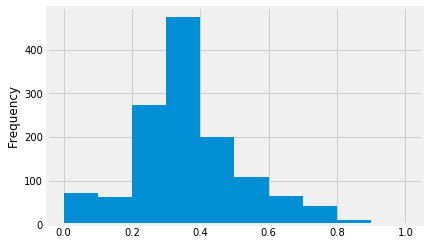

In [44]:
#注意：z-score,min-max这两种变换都是线性变换，不会改变分布形状
titanic_min_max_df['Age'].plot(kind='hist')

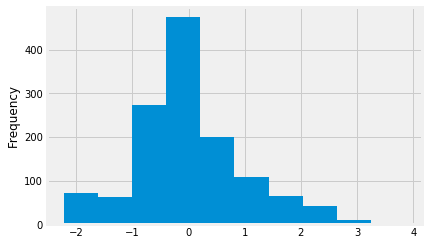

In [45]:
titanic_z_score_df['Age'].plot(kind='hist')

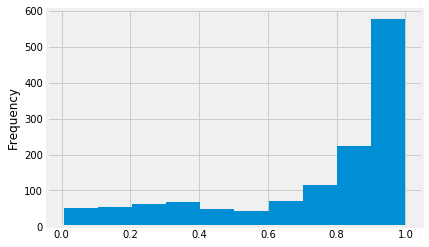

In [46]:
#行归一化会改变
titanic_normalize_df['Age'].plot(kind='hist')

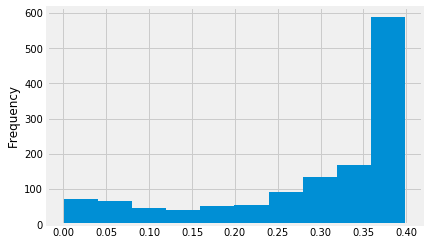

In [47]:
#pdf:标准正态分布的概率密度函数
from scipy.stats import norm
age_mean=features_df['Age'].mean()
age_std=features_df['Age'].std()
features_df['Age'].apply(lambda x:norm.pdf((x-age_mean)/age_std)).plot(kind='hist')

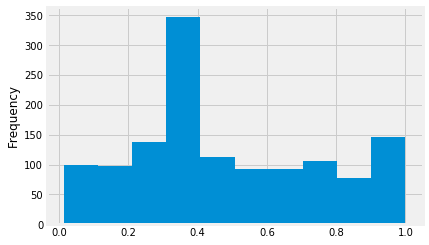

In [48]:
#cdf:分布函数
features_df['Age'].apply(lambda x:norm.cdf((x-age_mean)/age_std)).plot(kind='hist')

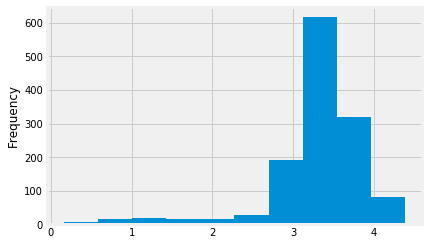

In [49]:
#log
features_df['Age'].apply(lambda x:np.log1p(x)).plot(kind='hist')

(array([ 51.,  35.,  48., 274., 478., 210., 118.,  55.,  32.,   8.]),
 array([-0.97171828,  2.70253966,  6.37679759, 10.05105553, 13.72531346,
        17.39957139, 21.07382933, 24.74808726, 28.42234519, 32.09660313,
        35.77086106]),
 <a list of 10 Patch objects>)

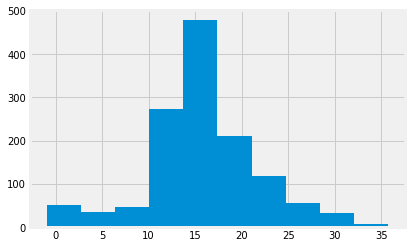

In [50]:
#boxcox
from scipy.stats import boxcox
plt.hist(boxcox(features_df['Age'])[0])

In [51]:
#最佳lambda
boxcox(features_df['Age'])[1]

0.7627222156380012

### 三.选择基准模型
（1）**目标**：本数据集是预测乘客是否存活，所以可以看做是分类任务；  
（2）**量化目标**：选择合适的评估指标，这里我们可以选择f1；  
（3）从分类模型中选择一个较优的模型作为基准模型，这是一个比较繁琐的工作；  

In [52]:
data_x=StandardScaler().fit_transform(features_df[:891])
#切分训练集测试集
X_train,X_test, y_train, y_test =train_test_split(data_x,labels,test_size=0.2, random_state=42)
#训练模型
classifier=LogisticRegression()
classifier.fit(X_train,y_train)
#预测数据
y_predict=classifier.predict(X_test)
#查看检测指标
f1_score=metrics.f1_score(y_test,y_predict)
f1_score

0.7862068965517242

In [53]:
#为了结果更加客观，可以做k-fold交叉验证，但会更耗时

classifier=LogisticRegression()
scores = cross_val_score(classifier, data_x, labels, scoring='f1', cv = 5)#注意：f1只是看正样本的f1,如果要看整体的用f1_macro,但这一般会使得f1偏高
#查看均值与标准差,均值反映模型的预测能力，标准差可以反映模型的稳定性
np.mean(scores),np.std(scores)

(0.759262777574798, 0.016196297194678546)

In [54]:
#我们再看看另一种分类器
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, features_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7724798337990278, 0.052794300926641495)

#### 定位模型能力：方差与偏差
可以参考下面图为我们的模型做定位：  
![avatar](./source/方差与偏差.png)
来源:https://blog.csdn.net/hertzcat/article/details/80035330

#### 检查过/欠拟合情况
过/欠拟合可以通过模型在训练集/验证集/测试集上的表现来评估，  
（1）训练集/验证集/测试集效果都比较差，可以看作是欠拟合(除非训练数据真的是太差了)，这时可以增加模型的复杂度试一试；  
（2）训练集的表现好，而验证集/测试集的表现差，一般就是过拟合（这也是经常会遇到的问题），可以下面的一些方式常识：  
    2.1）降低模型复杂度：1.换更简单的模型，2.正则化技术  
    2.2）增强训练数据  

In [55]:
#查看lr的训练集，测试集的情况
classifier=LogisticRegression()
classifier.fit(X_train,y_train)
y_test_predict=classifier.predict(X_test)
test_f1_score=metrics.f1_score(y_test,y_test_predict)

y_train_predict=classifier.predict(X_train)
train_f1_score=metrics.f1_score(y_train,y_train_predict)
print('train:',train_f1_score,'\t test:',test_f1_score)

train: 0.7630057803468208 	 test: 0.7862068965517242


In [56]:
#查看gbdt的训练集，测试集的情况
classifier=GradientBoostingClassifier()
classifier.fit(X_train,y_train)
y_test_predict=classifier.predict(X_test)
test_f1_score=metrics.f1_score(y_test,y_test_predict)

y_train_predict=classifier.predict(X_train)
train_f1_score=metrics.f1_score(y_train,y_train_predict)
print('train:',train_f1_score,'\t test:',test_f1_score)

train: 0.8641975308641976 	 test: 0.7826086956521738


可以发现gbdt有点过拟合了，lr很稳定，然后我们可以看出模型过拟合/欠拟合与模型方差/偏差的一些关系：  
（1）欠拟合模型往往偏差大（这里对应f1指标较小）  
（2）过拟合模型往往方差较大（这里对应f1的标准差较大）  
接下来可以通过降低gbdt中cart树数量的方式来降低模型复杂度：  

In [57]:
classifier=GradientBoostingClassifier(n_estimators=80)#默认是100
scores = cross_val_score(classifier, data_x, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7770062297307175, 0.04740066888740136)

In [58]:
classifier=GradientBoostingClassifier(n_estimators=80)
classifier.fit(X_train,y_train)
y_test_predict=classifier.predict(X_test)
test_f1_score=metrics.f1_score(y_test,y_test_predict)

y_train_predict=classifier.predict(X_train)
train_f1_score=metrics.f1_score(y_train,y_train_predict)
print('train:',train_f1_score,'\t test:',test_f1_score)

train: 0.8588957055214724 	 test: 0.7769784172661871


### 四.优化
对于建模的优化，可以自然的从三方面来考虑：  
（1）特征优化：扩展特征，特征选择，特征转换...  
（2）数据增强：过采样、根据数据特性造新数据、半监督学习...  
（3）模型优化：超参优化、模型集成...

#### 4.1.1 特征扩展：推理
凭借自己对数据的理解构建有意义的特征，比如：  
通过Cabin关联乘客的同行者的信息，根据前面的性别-存活率的热图，我们扩展这样的特征：是否有其他小孩(Age<=10), 是否有其他女性，是否有其他老人(age>=70),是否有其他青年男性（20<=Age<=50），以及当前cabin的人数

In [59]:
extend_df=origin_features_df[['PassengerId','Age','Sex','Name','Cabin']]
extend_df=extend_df[~extend_df['Cabin'].isnull()]

In [60]:
extend_df2=extend_df[['Age','Name','Sex','Cabin']]
extend_df2.columns=['Age2','Name2','Sex2','Cabin']

In [61]:
merge_df=pd.merge(extend_df,extend_df2,on='Cabin',how='left')

In [62]:
def check_has_other_child(name1,name2,age2):
    if name1==name2:
        return 0
    else:
        if age2<=10:
            return 1
        else:
            return 0
merge_df['Has_other_child']=merge_df.apply(lambda row:check_has_other_child(row['Name'],row['Name2'],row['Age2']),axis=1)

In [63]:
def check_has_other_female(name1,name2,sex2):
    if name1==name2:
        return 0
    else:
        if sex2=='female':
            return 1
        else:
            return 0
merge_df['Has_other_female']=merge_df.apply(lambda row:check_has_other_female(row['Name'],row['Name2'],row['Sex2']),axis=1)

In [64]:
def check_has_other_old(name1,name2,age2):
    if name1==name2:
        return 0
    else:
        if age2>=70:
            return 1
        else:
            return 0
merge_df['Has_other_old']=merge_df.apply(lambda row:check_has_other_old(row['Name'],row['Name2'],row['Age2']),axis=1)

In [65]:
def check_has_young_male(name1,name2,sex2,age2):
    if name1==name2:
        return 0
    else:
        if sex2=='male' and age2>=20 and age2<=50:
            return 1
        else:
            return 0
merge_df['Has_other_young_male']=merge_df.apply(lambda row:check_has_young_male(row['Name'],row['Name2'],row['Sex2'],row['Age2']),axis=1)

In [66]:
merge_df=merge_df[['PassengerId','Has_other_child','Has_other_female','Has_other_old','Has_other_young_male']]

In [67]:
#去重
gp_df=merge_df.groupby(by=['PassengerId']).agg({'Has_other_child':'max','Has_other_female':'max','Has_other_old':'max','Has_other_young_male':'max'}).reset_index()

In [68]:
gp_df.head(5)

,PassengerId,Has_other_child,Has_other_female,Has_other_old,Has_other_young_male
0,2,0,0,0,1
1,4,0,0,0,1
2,7,0,0,0,0
3,11,1,1,0,0
4,12,0,0,0,0


In [69]:
extend_df=pd.merge(origin_features_df[['PassengerId']],gp_df,on='PassengerId',how='left')
extend_df.fillna(0,inplace=True)

In [70]:
extend_df.head(5)

,PassengerId,Has_other_child,Has_other_female,Has_other_old,Has_other_young_male
0,1,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,1.0
2,3,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,1.0
4,5,0.0,0.0,0.0,0.0


In [71]:
del extend_df['PassengerId']
features_df=pd.concat([features_df,extend_df],axis=1)

In [72]:
features_df.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3,Has_other_child,Has_other_female,Has_other_old,Has_other_young_male
0,3,0,22.0,1,0,7.2500,0.299854,1,0,0,0.0,0.0,0.0,0.0
1,1,1,38.0,1,0,71.2833,0.383838,0,1,0,0.0,0.0,0.0,1.0
2,3,1,26.0,0,0,7.9250,0.299854,1,0,0,0.0,0.0,0.0,0.0
3,1,1,35.0,1,0,53.1000,0.468759,1,0,0,0.0,0.0,0.0,1.0
4,3,0,35.0,0,0,8.0500,0.299854,1,0,0,0.0,0.0,0.0,0.0


In [73]:
#检查效果
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, features_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7769165138086762, 0.045459742819809204)

#### 4.1.1 特征扩展：推理
之前我们删掉了Name，其实Name中的姓可以反应一些特征，比如Mrs可以放映出该乘客已经结婚，Miss表示未婚小姐姐，我们将其提取出来，另外SibSp表示乘客兄弟姐妹/配偶的个数，而Parch表示乘客父母/孩子的个数，可以简单相加表示他们的家庭成员多少，越多的存活率可能越高...  

更多:https://www.kaggle.com/gunesevitan/advanced-feature-engineering-tutorial-with-titanic

In [74]:
features_df['family_size']=features_df['SibSp']+features_df['Parch']+1

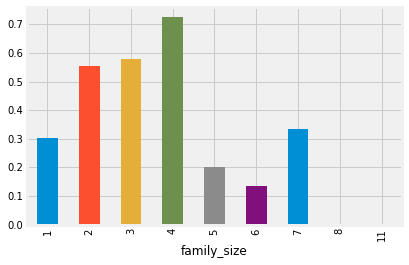

In [75]:
#统计存活率分布
show_df=features_df[:891]
show_df['Survived']=labels
show_df.groupby('family_size')['Survived'].mean().plot(kind='bar')

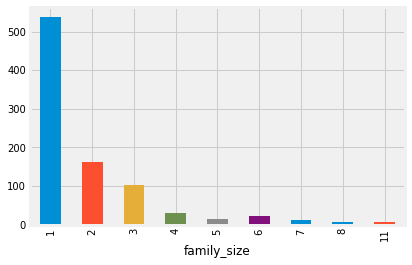

In [76]:
show_df.groupby('family_size')['Survived'].count().plot(kind='bar')

In [77]:
#提取姓名中的title
origin_features_df['Name'].apply(lambda name:name.split(',')[1].split('.')[0]).value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Dr                8
 Rev               8
 Col               4
 Major             2
 Ms                2
 Mlle              2
 Lady              1
 Jonkheer          1
 Dona              1
 Capt              1
 Don               1
 Sir               1
 Mme               1
 the Countess      1
Name: Name, dtype: int64

In [78]:
titles=['Mr','Miss','Mrs','Master']
def extract_title(name):
    for title in titles:
        if title in name:
            return title
    return 'Other'
features_df['name_title']=origin_features_df['Name'].apply(extract_title)

In [79]:
features_df=pd.get_dummies(features_df,columns=['name_title'])

In [80]:
features_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_1,Embarked_2,Embarked_3,Has_other_child,Has_other_female,Has_other_old,Has_other_young_male,family_size,name_title_Master,name_title_Miss,name_title_Mr,name_title_Other
0,3,0,22.0,1,0,7.2500,0.299854,1,0,0,0.0,0.0,0.0,0.0,2,0,0,1,0
1,1,1,38.0,1,0,71.2833,0.383838,0,1,0,0.0,0.0,0.0,1.0,2,0,0,1,0
2,3,1,26.0,0,0,7.9250,0.299854,1,0,0,0.0,0.0,0.0,0.0,1,0,1,0,0
3,1,1,35.0,1,0,53.1000,0.468759,1,0,0,0.0,0.0,0.0,1.0,2,0,0,1,0
4,3,0,35.0,0,0,8.0500,0.299854,1,0,0,0.0,0.0,0.0,0.0,1,0,0,1,0


In [81]:
#检查效果
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, features_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7863861150429007, 0.045106415307000484)

#### 4.1.1 扩展特征：添加聚类标签
聚类标签可以看作是对目前样本的做的特征映射，将高维空间相似的特征映射到相同的标签；  
这里演示用kmean生成聚类标签，利用calinski_harabaz选择较优的k，  
更多：https://blog.csdn.net/u010159842/article/details/78624135

In [82]:
cluster_data_np=StandardScaler().fit_transform(features_df)

Text(0,0.5,'distortion degree')

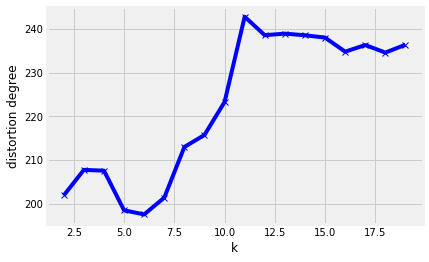

In [83]:
K=range(2,20)
calinski_harabaz_scores=[]
for k in K:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(cluster_data_np)
    calinski_harabaz_scores.append(metrics.calinski_harabaz_score(cluster_data_np, kmeans.predict(cluster_data_np)))
plt.plot(K,calinski_harabaz_scores,'bx-')
plt.xlabel('k')
plt.ylabel(u'distortion degree')

In [84]:
kmeans=KMeans(n_clusters=11)
kmeans.fit(cluster_data_np)
ext_cluster_fea_df=copy.deepcopy(features_df)
ext_cluster_fea_df['cluster_factor']=kmeans.predict(cluster_data_np)

In [85]:
ext_cluster_fea_dummy_df = pd.get_dummies(ext_cluster_fea_df,columns=['cluster_factor'])

In [86]:
#检查效果
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, ext_cluster_fea_dummy_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7909764830595335, 0.046701857326420175)

不过貌似这样选择的k做的聚类因子未必是最好的....可以多尝试几种...

#### 4.1.1  扩展特征：数值特征
对数值特征的扩展，可以考虑：  
（1）连续值分箱：某些特征分箱可能可以体现不一样的意义...  
（2）log变换等...改变原始数据的分布特性...  
（3）无脑构造多项式/交互特征：$[a,b]->[1,a,b,a^2,b^2,ab]$  
接下来试一试...

In [87]:
ext_fea_df=copy.deepcopy(ext_cluster_fea_dummy_df)
ext_fea_df['Age_bins']=pd.cut(ext_fea_df['Age'],bins=10,labels=False)#对age分箱
ext_fea_df['Fare_bins']=pd.cut(ext_fea_df['Fare'],bins=10,labels=False)#对Fare分箱
ext_fea_df['Age_log']=ext_fea_df['Age'].apply(lambda x:np.log1p(x))#log变换
ext_fea_df['Age_log_cdf']=ext_fea_df['Age_log'].apply(lambda x:norm.cdf((x-ext_fea_df['Age_log'].mean())/ext_fea_df['Age_log'].std()))#cdf变换

In [88]:
#lr
ext_fea_np=StandardScaler().fit_transform(ext_fea_df[:891])
classifier=LogisticRegression()
scores = cross_val_score(classifier, ext_fea_np, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.781605275854118, 0.028909134651025126)

In [89]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, ext_fea_np, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7864075819002644, 0.04520773057627748)

In [90]:
#构造交互特征：一般来说选择0/1类型的特征来构造更make sense
poly=PolynomialFeatures(degree=2,include_bias=False,interaction_only=False)#无脑多项式转换
poly_fea_np=poly.fit_transform(ext_fea_df)#这里是numpy类型
poly_fea_df=pd.DataFrame(poly_fea_np,columns=poly.get_feature_names())

**注意：构造多项式特征慎用，它以$O(n^2)$增涨特征量，如果原始有1000个特征，变换后会有100W个特征...**

In [91]:
poly_fea_df.head(5)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x30^2,x30 x31,x30 x32,x30 x33,x31^2,x31 x32,x31 x33,x32^2,x32 x33,x33^2
0,3.0,0.0,22.0,1.0,0.0,7.2500,0.299854,1.0,0.0,0.0,...,4.0,0.0,6.270988,0.808603,0.0,0.000000,0.000000,9.831324,1.267685,0.163460
1,1.0,1.0,38.0,1.0,0.0,71.2833,0.383838,0.0,1.0,0.0,...,16.0,4.0,14.654247,2.942756,1.0,3.663562,0.735689,13.421684,2.695242,0.541238
2,3.0,1.0,26.0,0.0,0.0,7.9250,0.299854,1.0,0.0,0.0,...,9.0,0.0,9.887511,1.527105,0.0,0.000000,0.000000,10.862541,1.677696,0.259117
3,1.0,1.0,35.0,1.0,0.0,53.1000,0.468759,1.0,0.0,0.0,...,16.0,4.0,14.334076,2.762870,1.0,3.583519,0.690717,12.841608,2.475199,0.477091
4,3.0,0.0,35.0,0.0,0.0,8.0500,0.299854,1.0,0.0,0.0,...,16.0,0.0,14.334076,2.762870,0.0,0.000000,0.000000,12.841608,2.475199,0.477091


In [92]:
poly_fea_df.shape

(1309, 629)

In [93]:
#看看在lr上的表现
classifier=LogisticRegression()
scores = cross_val_score(classifier, StandardScaler().fit_transform(poly_fea_df[:891]), labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7658800289334641, 0.03893924621871495)

In [94]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, poly_fea_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7857808128920959, 0.03875741625727451)

###### 特征数增加是否会影响模型稳定性？
这里发现特征量的快速增加（10->629），lr的std增加了很多，gbdt有所减少，这是因为特征数量的增加被动的增加了lr模型的复杂度($\sigma(w^Tx+b)$,模型的复杂度与$x$的维度正比)，而gbdt在生成树的时候对于用处不大的特征，选择的少或者压根不会选。

#### 4.1.1 特征扩展：离散特征
离散特征的扩展可以考虑特征组合，比如：  
（1）从make sense的情况下组合特征；  
（2）自动特征组合...

#### make sense的特征
构造乘客性别和票类型的组合特征：

Pclass |  Sex  
-|-
1 | male |
2 | female |  
转换为：  

Pclass_1_female |  Pclass_2_female | Pclass_3_female |  Pclass_1_male |Pclass_2_male |  Pclass_3_male  
-|-|-|-|-|-
0|0|0|1|0|0
0|1|0|0|0|0 


In [95]:
def combine_pclass_sex(pclass,sex):
    if sex=='male':
        return pclass-1
    else:
        return pclass+2
ext_cat_fea_df=copy.deepcopy(poly_fea_df)
ext_cat_fea_df['Pclass_Sex']=origin_features_df.apply(lambda row:combine_pclass_sex(row['Pclass'],row['Sex']),axis=1)
ext_cat_fea_dummy_df = pd.get_dummies(ext_cat_fea_df,columns=['Pclass_Sex'])

In [96]:
ext_cat_fea_dummy_df.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'x31 x33', 'x32^2', 'x32 x33', 'x33^2', 'Pclass_Sex_0', 'Pclass_Sex_1',
       'Pclass_Sex_2', 'Pclass_Sex_3', 'Pclass_Sex_4', 'Pclass_Sex_5'],
      dtype='object', length=635)

In [97]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, ext_cat_fea_dummy_df[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7901276492525999, 0.037810466599126666)

#### 4.1.1 特征扩展：自动构建组合特征
比较流行的一种方式是gbdt+lr,即利用gbdt探索不错的特征空间，然后用lr对这些特征空间张成one-hot特征进行拟合；  
![avatar](./source/gbdt_lr.png)
参考：https://www.cnblogs.com/wkang/p/9657032.html

In [98]:
from sklearn.preprocessing import OneHotEncoder
n_trees=100
tree_depth=2#树的深度不必太深
kfold= KFold(n_splits=5,shuffle=True)
scores=[]
for train_index,test_index in kfold.split(ext_cat_fea_dummy_df[:891],labels):
    X_train=ext_cat_fea_dummy_df.loc[train_index]
    y_train=labels[train_index]
    X_test=ext_cat_fea_dummy_df.loc[test_index]
    y_test=labels[test_index]
    
    gbm1 = GradientBoostingClassifier(n_estimators=n_trees,max_depth=tree_depth)
    gbm1.fit(X_train, y_train)
    train_new_feature = gbm1.apply(X_train)
    train_new_feature = train_new_feature.reshape(-1, n_trees)

    enc = OneHotEncoder()

    enc.fit(train_new_feature)

    # # # 每一个属性的最大取值数目
    # # print('每一个特征的最大取值数目:', enc.n_values_)
    # # print('所有特征的取值数目总和:', enc.n_values_.sum())

    train_new_feature2 = np.array(enc.transform(train_new_feature).toarray())

    #训练lr
    lr=LogisticRegression()
    lr.fit(train_new_feature2,y_train)
    #测试
    test_new_feature = gbm1.apply(X_test)
    test_new_feature = test_new_feature.reshape(-1, n_trees)
    test_new_feature2 = np.array(enc.transform(test_new_feature).toarray())

    y_predict=lr.predict(test_new_feature2)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7828570540978197, 0.03572936557369643)

**通过一系列的特征扩展，我们将baseline gbdt从f1=0.776,std=0.045提升到f1=0.790,std=0.037；此时的最优fetures为ext_cat_fea_dummy_df，接下来我们的目标是去掉那些噪声特征，利用尽可能少的特征去建模达到和之前模型一样的效果；**  
#### 4.1.2 特征选择
（1）基于统计：方差、相关性、gini、info gain、chi2    
（2）基于模型：RFE递归删减特征、训练基模型，选择权值系数较高的特征  

更多:https://www.jianshu.com/p/1c4ec02dd33f

##### 4.1.2 特征选择-方差
将方差较低的特征过滤掉

In [99]:
var_standard_df=StandardScaler().fit_transform(ext_cat_fea_dummy_df[:891])
VarianceThreshold(threshold=0.01).fit_transform(var_standard_df).shape

(891, 494)

In [100]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, VarianceThreshold(threshold=0.01).fit_transform(ext_cat_fea_dummy_df[:891]), labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7864464540519065, 0.04470351468704984)

##### 4.1.2 特征选择-相关性
选择与y标签相关性top的因子建模

In [101]:
ext_cat_fea_add_y_df=copy.deepcopy(ext_cat_fea_dummy_df[:891])
ext_cat_fea_add_y_df['Survived']=labels
ext_cat_fea_add_y_df.corr()['Survived'].abs().sort_values(ascending=False).head(5)

Survived    1.000000
x1^2        0.543351
x1          0.543351
x1 x6       0.541299
x1 x32      0.539657
Name: Survived, dtype: float64

In [102]:
#选择相关性>0.2的因子建模，注意要去掉Survived
highly_correlated_features = ext_cat_fea_add_y_df.columns[ext_cat_fea_add_y_df.corr()['Survived'].abs() > 0.1]
highly_correlated_features = highly_correlated_features.drop('Survived')
high_corr_features_df=ext_cat_fea_add_y_df[highly_correlated_features]

In [103]:
high_corr_features_df.shape

(891, 216)

In [104]:
high_corr_features_df.head(5)

,x0,x1,x5,x6,x7,x8,x11,x13,x16,x17,...,x29 x33,x30 x31,x31^2,x31 x32,x31 x33,Pclass_Sex_1,Pclass_Sex_2,Pclass_Sex_3,Pclass_Sex_4,Pclass_Sex_5
0,3.0,0.0,7.2500,0.299854,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.000000,0,1,0,0,0
1,1.0,1.0,71.2833,0.383838,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,4.0,1.0,3.663562,0.735689,0,0,1,0,0
2,3.0,1.0,7.9250,0.299854,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0,0,0,0,1
3,1.0,1.0,53.1000,0.468759,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,4.0,1.0,3.583519,0.690717,0,0,1,0,0
4,3.0,0.0,8.0500,0.299854,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.000000,0,1,0,0,0


In [105]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, high_corr_features_df, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7982230871110236, 0.04005021178757985)

**注意：如果出现与y标签相关性很高的因子要引起重视，它可能是由y=>的因子，这种情况应该删掉，因为在test集中这部分因子可能是NaN**
##### 4.1.2 特征选择-Gini指数
gini指数的计算很简单，训练一个决策树就好了

In [106]:
tree = DecisionTreeClassifier()#如果要用信息增益，设置criterion='entropy'
tree.fit(ext_cat_fea_dummy_df[:891],labels)
importances = pd.DataFrame({ 'feature':ext_cat_fea_dummy_df.columns,'importance': tree.feature_importances_}).sort_values('importance', ascending=False)

In [107]:
importances.head()

,feature,importance
72,x1 x5,0.307929
41,x0 x7,0.081971
223,x6^2,0.060021
66,x0 x32,0.048030
222,x5 x33,0.034275


In [108]:
#选择top因子建模
select_features=importances['feature'].tolist()[:50]
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, ext_cat_fea_dummy_df[:891][select_features], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7814714018467808, 0.03967256128537211)

##### 4.1.2-chi2选择

In [109]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [110]:
min_max_standard_df=MinMaxScaler().fit_transform(ext_cat_fea_dummy_df[:891])#chi2要求每一项都>0

In [111]:
#选择前50个特征
top_50_features=SelectKBest(chi2, k=50).fit_transform(min_max_standard_df, labels)

In [112]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, top_50_features, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7445836007787162, 0.03280535827045528)

##### 4.1.2-RFE递归消除

In [113]:
# from sklearn.feature_selection import RFE
# rfe_df=RFE(estimator=GradientBoostingClassifier(), n_features_to_select=50).fit_transform(ext_cat_fea_dummy_df[:891], labels)

**这里相当的慢**

In [114]:
# #gbdt
# classifier=GradientBoostingClassifier()
# scores = cross_val_score(classifier, rfe_df, labels, scoring='f1', cv = 5)
# np.mean(scores),np.std(scores)

#### 4.1.2-基于模型选特征
其实这里和gini系数的选择一样，通过训练一个模型来选择特征最优特征，然后再去训练一个模型，只是这里选择特征用的模型与训练用的模型一样

In [115]:
#也可以直接用我们gbdt筛选后的特征
tree = GradientBoostingClassifier()
tree.fit(ext_cat_fea_dummy_df[:891],labels)
importances = pd.DataFrame({ 'feature':ext_cat_fea_dummy_df.columns,'importance': tree.feature_importances_}).sort_values('importance', ascending=False)
importances.head()

,feature,importance
72,x1 x5,0.410788
41,x0 x7,0.061809
66,x0 x32,0.055152
223,x6^2,0.041650
36,x0 x2,0.026148


In [116]:
#选择top因子建模
select_features=importances['feature'].tolist()[:50]
features_select_top_50_df=ext_cat_fea_dummy_df[select_features]
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,features_select_top_50_df[:891],labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.790842413430348, 0.03884122466716893)

也可以使用SelectFromModel自动选择最优的top n因子

In [117]:
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
top_nums=[]
for train_index,test_index in kfold.split(ext_cat_fea_dummy_df[:891],labels):
    X_train=ext_cat_fea_dummy_df.loc[train_index]
    y_train=labels[train_index]
    X_test=ext_cat_fea_dummy_df.loc[test_index]
    y_test=labels[test_index]
    
    select_feature_model = SelectFromModel(GradientBoostingClassifier())
    X_new_train=select_feature_model.fit_transform(X_train,y_train)
    
    X_new_test=select_feature_model.transform(X_test)
    
    _,top_num=X_new_test.shape
    top_nums.append(top_num)
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(X_new_train,y_train)
    y_predict=gbdt.predict(X_new_test)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7952062793127788, 0.04419730020649977)

In [118]:
np.mean(top_nums)

63.2

##### **注意：之前的特征选择操作都不太严谨，因为是将训练集和验证集合并在一起做的特征选择，再用cv的方式看一下**

In [119]:
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
for train_index,test_index in kfold.split(ext_cat_fea_dummy_df[:891],labels):
    X_train=ext_cat_fea_dummy_df.loc[train_index]
    y_train=labels[train_index]
    X_test=ext_cat_fea_dummy_df.loc[test_index]
    y_test=labels[test_index]
    
    tree = GradientBoostingClassifier()
    tree.fit(X_train,y_train)
    importances = pd.DataFrame({ 'feature':X_train.columns,'importance': tree.feature_importances_}).sort_values('importance', ascending=False)
    
    select_features=importances['feature'].tolist()[:50]
    
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(X_train[select_features],y_train)
    y_predict=gbdt.predict(X_test[select_features])
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7866146703907528, 0.05346996087808893)

发现其实只需要1/10的因子就能达到和之前一样的效果，甚至更好....  

#### 4.1.3 特征转换
特征选择是从当前的特征集中选择一个子集，而特征转换是对feature/feature和label做某些数学操作，转换后的特征不在是之前特征的子集，比如：  
（1）pca:主成分分析；  
（2）lda:线性判别分析；  
（3）lle:局部线性嵌入；  
（4）ae:自编码；

##### 4.1.3-pca
pca是一种无监督的线性降维方式，它构建了一个新的正交坐标系，相应的坐标轴分别叫“第一主成分”，“第二主成分”...，且数据在“第一主成分”坐标轴上**方差**最大，“第二主成分”其次，...通常可以只取前n个主成分，将方差较小的主成分理解为**噪声**；  
![avatar](./source/pca示例.png)
更多：https://blog.csdn.net/program_developer/article/details/80632779 

In [120]:
from sklearn.decomposition import PCA
standard_df=StandardScaler().fit_transform(features_select_top_50_df)
X_pca=PCA(n_components=20).fit_transform(standard_df)

In [121]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,X_pca[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7659525233538391, 0.0257880424604624)

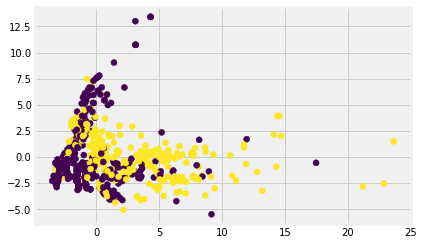

In [122]:
plt.scatter(X_pca[:891][:, 0], X_pca[:891][:, 1],marker='o',c=labels)
plt.show()

#### 4.1.3-lda
lda是一种线性的有监督降维方式，与pca的最大化方差的目标不同，它的目标是找到这样的新坐标轴：**同类样例的投影尽可能近，异类样例的投影点尽可能远**；  
更多：https://blog.csdn.net/weixin_40604987/article/details/79615968

In [123]:
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
standard_np=StandardScaler().fit_transform(features_select_top_50_df)
for train_index,test_index in kfold.split(standard_np[:891],labels):
    X_train=standard_np[train_index]
    y_train=labels[train_index]
    X_test=standard_np[test_index]
    y_test=labels[test_index]
    
    lda=LinearDiscriminantAnalysis(n_components=20)
    lda.fit(X_train, y_train)
    
    X_new_train=lda.transform(X_train)
    X_new_test=lda.transform(X_test)
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(X_new_train,y_train)
    y_predict=gbdt.predict(X_new_test)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7460656054841958, 0.042041162734238115)

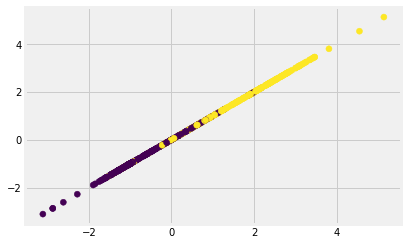

In [124]:
plt.scatter(X_new_train[:891][:, 0], X_new_train[:891][:, 0],marker='o',c=y_train)
plt.show()

#### 4.1.3 lle-局部线性嵌入（LocallyLinearEmbedding）
降维时保持样本局部的线性特征
![avatar](./source/lle示例.jpg)
更多：https://www.cnblogs.com/pinard/p/6266408.html?utm_source=itdadao&utm_medium=referral

In [125]:
from sklearn.manifold import LocallyLinearEmbedding
standard_df=StandardScaler().fit_transform(features_select_top_50_df)
X_lle=LocallyLinearEmbedding(n_components=20).fit_transform(standard_df)

In [126]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,X_lle[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7593378531368846, 0.03120998584387323)

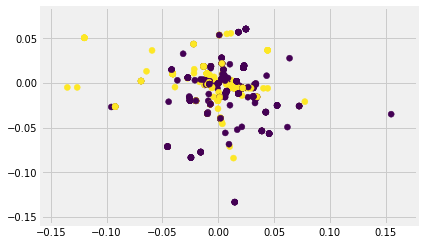

In [127]:
plt.scatter(X_lle[:891][:, 0], X_lle[:891][:, 1],marker='o',c=labels)
plt.show()

#### 4.1.4 ae-自编码
预测目标就是输入目标，可以把它看做一个压缩和解压的过程，如下，通过encoder把一个高维的数据压缩为低维的数据，通过decoder将低维数据还原为高维的数据，这样这个低维的数据可以看做高维数据的一种“不失真”表示；    
![avatar](./source/ae示例.jpg)
ae在图像和nlp方面都有很多深入的应用，比如cv中的vae，nlp中的bert等...  
更多：https://blog.csdn.net/leida_wt/article/details/85052299

In [128]:
from keras.models import Model
from keras.layers import *
# 指定显卡
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# 动态申请显存
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # 不全部占满显存, 按需分配
sess = tf.Session(config=config)
KTF.set_session(sess)

Using TensorFlow backend.


In [129]:
#定义网络结构
epochs=200
batch_size=128
input_dim=50

input_layer=Input(shape=(input_dim,))
encode_layer=Dense(2,activation='relu',name='encoder')(input_layer)
decode_layer=Dense(input_dim,activation='tanh')(encode_layer)

model=Model(inputs=input_layer,outputs=decode_layer)
#获取encode_layer层的输出
encode_layer_model = Model(inputs=model.input,outputs=model.get_layer('encoder').output)
model.compile('adam',loss='mse')

In [130]:
#预处理输入数据
ae_standard_np=StandardScaler().fit_transform(features_select_top_50_df)

In [131]:
X_train=ae_standard_np[:1200]
X_eval=ae_standard_np[1200:]

In [132]:
X_train.shape,X_eval.shape

((1200, 50), (109, 50))

In [133]:
#训练模型
model.fit(X_train,X_train,batch_size=batch_size,epochs=epochs,validation_data=[X_eval,X_eval])

Train on 1200 samples, validate on 109 samples
Epoch 1/200
1200/1200 [==============================] - 0s 284us/step - loss: 1.0289 - val_loss: 1.2741
Epoch 2/200
1200/1200 [==============================] - 0s 20us/step - loss: 1.0130 - val_loss: 1.2590
Epoch 3/200
1200/1200 [==============================] - 0s 21us/step - loss: 1.0011 - val_loss: 1.2474
Epoch 4/200
1200/1200 [==============================] - 0s 21us/step - loss: 0.9924 - val_loss: 1.2385
Epoch 5/200
1200/1200 [==============================] - 0s 21us/step - loss: 0.9857 - val_loss: 1.2318
Epoch 6/200
1200/1200 [==============================] - 0s 21us/step - loss: 0.9803 - val_loss: 1.2251
Epoch 7/200
1200/1200 [==============================] - 0s 21us/step - loss: 0.9753 - val_loss: 1.2163
Epoch 8/200
1200/1200 [==============================] - 0s 20us/step - loss: 0.9705 - val_loss: 1.2051
Epoch 9/200
1200/1200 [==============================] - 0s 21us/step - loss: 0.9649 - val_loss: 1.1930
Epoch 10/200
120

1200/1200 [==============================] - 0s 20us/step - loss: 0.6644 - val_loss: 0.8916
Epoch 156/200
1200/1200 [==============================] - 0s 20us/step - loss: 0.6642 - val_loss: 0.8915
Epoch 157/200
1200/1200 [==============================] - 0s 19us/step - loss: 0.6641 - val_loss: 0.8913
Epoch 158/200
1200/1200 [==============================] - 0s 19us/step - loss: 0.6640 - val_loss: 0.8917
Epoch 159/200
1200/1200 [==============================] - 0s 18us/step - loss: 0.6639 - val_loss: 0.8914
Epoch 160/200
1200/1200 [==============================] - 0s 18us/step - loss: 0.6638 - val_loss: 0.8909
Epoch 161/200
1200/1200 [==============================] - 0s 19us/step - loss: 0.6637 - val_loss: 0.8911
Epoch 162/200
1200/1200 [==============================] - 0s 20us/step - loss: 0.6636 - val_loss: 0.8911
Epoch 163/200
1200/1200 [==============================] - 0s 18us/step - loss: 0.6635 - val_loss: 0.8911
Epoch 164/200
1200/1200 [==============================] - 0

In [134]:
X_eval[0]

array([-0.05346571,  1.07885292,  1.45989574, -0.31540135,  2.41822112,
       -0.30134655, -0.35524414, -0.31508197,  2.25949286, -0.22137801,
        0.87936559,  2.24948554,  0.36739393, -0.18690475,  0.36795947,
        1.93572254,  0.77516707, -0.35569965, -0.3347291 ,  1.68030492,
       -0.19883136,  1.06873154,  0.34181263, -0.37098818, -0.09205746,
       -0.20537302,  0.823777  , -0.19815661, -0.22115082,  0.84191642,
        1.03692279, -0.19660805, -0.10208177, -0.11772483, -0.05586586,
        0.60720133,  0.02367394, -0.20716782, -0.18598453, -0.24990615,
        0.47486479, -0.08320503,  2.20879186,  0.48775033, -0.15412406,
        1.42880154, -0.11772483,  1.78130624, -0.20339208,  2.21576743])

In [135]:
model.predict(X_eval)[0]

array([-0.0801675 ,  0.07296682,  0.41939336, -0.24811772, -0.03432285,
       -0.10558274, -0.28374588, -0.39323986, -0.0539648 , -0.40869796,
        0.69578105,  0.7121193 , -0.5070763 , -0.14108536,  0.23965408,
        0.74424994,  0.25377718, -0.3518952 ,  0.502023  ,  0.6239335 ,
        0.32818064, -0.34520072,  0.59817564, -0.3514654 , -0.24084517,
       -0.4016987 , -0.02132083,  0.1887731 , -0.4175932 ,  0.6987827 ,
       -0.7171223 ,  0.02379587,  0.18329269,  0.07201558,  0.26122534,
        0.592915  , -0.47993666, -0.24775195, -0.4004705 , -0.0052062 ,
       -0.5650685 , -0.237046  ,  0.43315473, -0.56589836, -0.2872388 ,
       -0.60540956,  0.07213464, -0.7194849 ,  0.092356  ,  0.41038588],
      dtype=float32)

In [136]:
encode_layer_model.predict(X_eval)[0]

array([0.22013885, 0.        ], dtype=float32)

In [137]:
np.mean(X_eval-model.predict(X_eval)),np.std(X_eval-model.predict(X_eval))

(0.06454085580063489, 0.940818802140507)

In [138]:
ae_new_features=encode_layer_model.predict(ae_standard_np)

In [139]:
ae_new_features.shape

(1309, 2)

In [140]:
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,ae_new_features[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.6325610416519508, 0.06452637259580173)

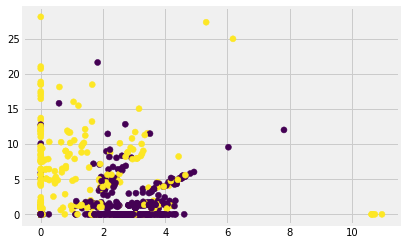

In [141]:
plt.scatter(ae_new_features[:891][:, 0], ae_new_features[:891][:, 1],marker='o',c=labels)
plt.show()

特征转换似乎都不能提高效果

##### 特征增强总结
特征增强很关键，是后续操作的基础，其实最有用的在于造出make sense的特征，从之前的操作来看我们造了几个make sense的特征就立即把模型从0.77+提升到了0.78+，而通过后续一系列的复杂特征变换（聚类、交互特征、特征选择...）才从0.78+提升到0.79+，接下来我们在features_select_top_50_df基础上尝试一些数据增强的方式；  

#### 4.2 数据增强
提供更多数据给模型训练，可从两方面来考虑：  

（1）利用其余的未标记数据进行无监督学习，在我们的标记数据进行监督学习（半监督学习），比如nlp任务中收集海量的文本数据训练embedding，然后再在其他nlp任务上做fine tuning；  
（2）在当前数据的基础上造出相似的数据，比如nlp任务中删除某一个词、替换同义词...，cv任务中缩放、旋转、翻转图片、gan...

##### 4.2.1 数据增强-半监督学习
这里没有多余的feature数据，我们假设test部分就是多出来的部分；  

在pca上做对比...

In [142]:
#增强前
standard_df=StandardScaler().fit_transform(features_select_top_50_df[:891])
X_pca=PCA(n_components=20).fit_transform(standard_df)
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,X_pca, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7728644604211258, 0.03638365981891742)

In [143]:
#增强后
standard_df=StandardScaler().fit_transform(features_select_top_50_df)
X_pca=PCA(n_components=20).fit_transform(standard_df)
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,X_pca[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7643321822324359, 0.025163060923998136)

在ae上对比...

In [144]:
#增强前
#定义网络结构
epochs=200
batch_size=128
input_dim=50

input_layer=Input(shape=(input_dim,))
encode_layer=Dense(20,activation='relu',name='encoder')(input_layer)
decode_layer=Dense(input_dim,activation='tanh')(encode_layer)

model=Model(inputs=input_layer,outputs=decode_layer)
#获取encode_layer层的输出
encode_layer_model = Model(inputs=model.input,outputs=model.get_layer('encoder').output)
model.compile('adam',loss='mse')

ae_standard_np=StandardScaler().fit_transform(features_select_top_50_df[:891])
X_train=ae_standard_np[:750]
X_eval=ae_standard_np[750:]

#训练模型
model.fit(X_train,X_train,batch_size=batch_size,epochs=epochs,validation_data=[X_eval,X_eval])
ae_new_features=encode_layer_model.predict(ae_standard_np)
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,ae_new_features, labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

Train on 750 samples, validate on 141 samples
Epoch 1/200
750/750 [==============================] - 0s 238us/step - loss: 1.1226 - val_loss: 1.1079
Epoch 2/200
750/750 [==============================] - 0s 24us/step - loss: 1.0751 - val_loss: 1.0638
Epoch 3/200
750/750 [==============================] - 0s 24us/step - loss: 1.0310 - val_loss: 1.0241
Epoch 4/200
750/750 [==============================] - 0s 21us/step - loss: 0.9912 - val_loss: 0.9889
Epoch 5/200
750/750 [==============================] - 0s 23us/step - loss: 0.9543 - val_loss: 0.9559
Epoch 6/200
750/750 [==============================] - 0s 21us/step - loss: 0.9204 - val_loss: 0.9242
Epoch 7/200
750/750 [==============================] - 0s 25us/step - loss: 0.8892 - val_loss: 0.8936
Epoch 8/200
750/750 [==============================] - 0s 21us/step - loss: 0.8588 - val_loss: 0.8638
Epoch 9/200
750/750 [==============================] - 0s 23us/step - loss: 0.8307 - val_loss: 0.8349
Epoch 10/200
750/750 [=============

750/750 [==============================] - 0s 20us/step - loss: 0.4354 - val_loss: 0.4468
Epoch 159/200
750/750 [==============================] - 0s 21us/step - loss: 0.4352 - val_loss: 0.4466
Epoch 160/200
750/750 [==============================] - 0s 23us/step - loss: 0.4351 - val_loss: 0.4465
Epoch 161/200
750/750 [==============================] - 0s 21us/step - loss: 0.4349 - val_loss: 0.4464
Epoch 162/200
750/750 [==============================] - 0s 23us/step - loss: 0.4348 - val_loss: 0.4462
Epoch 163/200
750/750 [==============================] - 0s 21us/step - loss: 0.4346 - val_loss: 0.4461
Epoch 164/200
750/750 [==============================] - 0s 24us/step - loss: 0.4344 - val_loss: 0.4460
Epoch 165/200
750/750 [==============================] - 0s 20us/step - loss: 0.4343 - val_loss: 0.4458
Epoch 166/200
750/750 [==============================] - 0s 21us/step - loss: 0.4342 - val_loss: 0.4456
Epoch 167/200
750/750 [==============================] - 0s 24us/step - loss: 

(0.7569819497061395, 0.049828372699125385)

In [145]:
#增强后
epochs=200
batch_size=128
input_dim=50

input_layer=Input(shape=(input_dim,))
encode_layer=Dense(20,activation='relu',name='encoder')(input_layer)
decode_layer=Dense(input_dim,activation='tanh')(encode_layer)

model=Model(inputs=input_layer,outputs=decode_layer)
#获取encode_layer层的输出
encode_layer_model = Model(inputs=model.input,outputs=model.get_layer('encoder').output)
model.compile('adam',loss='mse')

ae_standard_np=StandardScaler().fit_transform(features_select_top_50_df)
X_train=ae_standard_np[:1200]
X_eval=ae_standard_np[1200:]

#训练模型
model.fit(X_train,X_train,batch_size=batch_size,epochs=epochs,validation_data=[X_eval,X_eval])
ae_new_features=encode_layer_model.predict(ae_standard_np)
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,ae_new_features[:891], labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

Train on 1200 samples, validate on 109 samples
Epoch 1/200
1200/1200 [==============================] - 0s 168us/step - loss: 1.1974 - val_loss: 1.4508
Epoch 2/200
1200/1200 [==============================] - 0s 23us/step - loss: 1.1098 - val_loss: 1.3536
Epoch 3/200
1200/1200 [==============================] - 0s 20us/step - loss: 1.0331 - val_loss: 1.2675
Epoch 4/200
1200/1200 [==============================] - 0s 21us/step - loss: 0.9674 - val_loss: 1.1947
Epoch 5/200
1200/1200 [==============================] - 0s 21us/step - loss: 0.9077 - val_loss: 1.1222
Epoch 6/200
1200/1200 [==============================] - 0s 22us/step - loss: 0.8521 - val_loss: 1.0558
Epoch 7/200
1200/1200 [==============================] - 0s 19us/step - loss: 0.8022 - val_loss: 1.0012
Epoch 8/200
1200/1200 [==============================] - 0s 21us/step - loss: 0.7577 - val_loss: 0.9569
Epoch 9/200
1200/1200 [==============================] - 0s 19us/step - loss: 0.7186 - val_loss: 0.9200
Epoch 10/200
120

1200/1200 [==============================] - 0s 23us/step - loss: 0.4146 - val_loss: 0.6321
Epoch 156/200
1200/1200 [==============================] - 0s 19us/step - loss: 0.4145 - val_loss: 0.6319
Epoch 157/200
1200/1200 [==============================] - 0s 19us/step - loss: 0.4144 - val_loss: 0.6318
Epoch 158/200
1200/1200 [==============================] - 0s 21us/step - loss: 0.4143 - val_loss: 0.6318
Epoch 159/200
1200/1200 [==============================] - 0s 21us/step - loss: 0.4142 - val_loss: 0.6316
Epoch 160/200
1200/1200 [==============================] - 0s 19us/step - loss: 0.4141 - val_loss: 0.6315
Epoch 161/200
1200/1200 [==============================] - 0s 21us/step - loss: 0.4140 - val_loss: 0.6315
Epoch 162/200
1200/1200 [==============================] - 0s 20us/step - loss: 0.4139 - val_loss: 0.6313
Epoch 163/200
1200/1200 [==============================] - 0s 22us/step - loss: 0.4138 - val_loss: 0.6312
Epoch 164/200
1200/1200 [==============================] - 0

(0.7720684816610016, 0.03739811487545861)

另外，对NaN的填充，仅用训练数据和用增强后的数据也可以做对比.....

##### 4.2.2 数据增强-过采样
这里推荐imblearn工具  
pip install imblearn

In [146]:
from imblearn.over_sampling import SMOTE
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
for train_index,test_index in kfold.split(features_select_top_50_df[:891],labels):
    X_train=features_select_top_50_df.loc[train_index]
    y_train=labels[train_index]
    X_test=features_select_top_50_df.loc[test_index]
    y_test=labels[test_index]
    
    X_resampled,y_resampled=SMOTE(k_neighbors=5).fit_sample(X_train,y_train)
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(X_resampled,y_resampled)
    y_predict=gbdt.predict(X_test)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7980725519186527, 0.06038700899362779)

##### 4.2.2 数据增强-自定义规则
对每条训练数据做如下操作：  
（1）随机删掉某个特征（0替换）；  
（2）随机交换同class的某个特征的值；  
（3）随机交换非class的某个特征的值；  

In [147]:
def extend_data(train_df,train_y):
    #删除操作
    rows,cols=train_df.shape
    delete_df=copy.deepcopy(train_df)
    for i in range(0,rows):
        j=random.choice(range(0,cols))
        delete_df.iloc[i,j]=0#注意：要用iloc[i,j]的方式才能成功赋值，loc[i,j],iloc[i][j],iloc[i,j]的方式都不行
    #替换操作
    replace_df=copy.deepcopy(train_df)
    zero_class_df=train_df[train_y==0]
    one_class_df=train_df[train_y==1]
    zero_rows,_=zero_class_df.shape
    one_rows,_=one_class_df.shape
    for i in range(0,rows):
        j=random.choice(range(0,cols))
        if train_y.tolist()[i]==0:
            new_i=random.choice(range(0,zero_rows))
            replace_df.iloc[i,j]=zero_class_df.iloc[new_i,j]
        else:
            new_i=random.choice(range(0,one_rows))
            replace_df.iloc[i,j]=one_class_df.iloc[new_i,j]
    #替换操作
    replace_df2=copy.deepcopy(train_df)
    for i in range(0,rows):
        j=random.choice(range(0,cols))
        if train_y.tolist()[i]==0:
            new_i=random.choice(range(0,one_rows))
            replace_df2.iloc[i,j]=one_class_df.iloc[new_i,j]
        else:
            new_i=random.choice(range(0,zero_rows))
            replace_df2.iloc[i,j]=zero_class_df.iloc[new_i,j]
    #合并
    return pd.concat([train_df,delete_df,replace_df,replace_df2]),train_y.tolist()*4

In [148]:
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
for train_index,test_index in kfold.split(features_select_top_50_df[:891],labels):
    X_train=features_select_top_50_df.loc[train_index]
    y_train=labels[train_index]
    X_test=features_select_top_50_df.loc[test_index]
    y_test=labels[test_index]
    
    X_extended,y_extended=extend_data(X_train,y_train)
    X_extended2,y_extended2=extend_data(X_train,y_train)
    X_extended3,y_extended3=extend_data(X_train,y_train)
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(pd.concat([X_train,X_extended,X_extended2,X_extended3]),y_train.tolist()+y_extended+y_extended2+y_extended3)
    y_predict=gbdt.predict(X_test)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7943138820002174, 0.05290963110392158)

这里把数据扩了12倍，多次运行，绝大部分情况下f1>0.8，当然，我们也可以与过采样的方法结合起来

#### 4.3模型优化  
模型的优化，可以考虑：  
（1）单模型优化：超参搜索；  
（2）多模型集成：集成学习；  

##### 4.3.1 超参数搜索
超参是指需要人为设定的参数，比如前面gbdt中的```n_estimators,max_depth,learning_rate```等；目前常见的超参搜索有网格搜索、随机搜索、贝叶斯优化搜索，还有基于强化学习的，比如google vizier...，其实比较好的方法是“人工智能”搜索（只需要一个excel表，并记录到相关操作对结果的改变就好了<坏结果也要保留>），接下来我们就在features_select_top_50_df数据集以及gbdt模型的基础上演示网格搜索、随机搜索、贝叶斯搜索...

##### 4.3.1 超参数搜索-网格搜索
网格搜索是将超参搜索空间切分成许多网格，我们在这些交点上选择一个较优秀的超参，但由于优化目标往往非凸，最优参数往往会成为漏网之鱼，通常比较建议的一种方式是在大范围内进行初步搜索，然后再在小范围内精确搜索。

In [149]:
from sklearn.model_selection import GridSearchCV
#定义搜索空间
gdbt_parameters = {'max_depth': [3,4,5],'learning_rate':[0.1,0.15,0.2],'n_estimators':[50,80,100,150]}
#定义模型
gbdt=GradientBoostingClassifier()
#进行搜索
grid = GridSearchCV(gbdt, gdbt_parameters,scoring='f1')
grid.fit(features_select_top_50_df[:891], labels)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  pre

In [150]:
grid.best_score_

0.7863140910838073

In [151]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}

In [152]:
#试一试这组参数
classifier=GradientBoostingClassifier(n_estimators=80,max_depth=3,learning_rate=0.15)
scores = cross_val_score(classifier,features_select_top_50_df[:891],labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7966830628425867, 0.031917708208678376)

##### 4.3.1超参数搜索-随机搜索
更多：https://blog.csdn.net/qq_36810398/article/details/86699842

In [153]:
from sklearn.model_selection import RandomizedSearchCV
#定义搜索空间
gdbt_parameters = {'max_depth': [3,4,5],'learning_rate':[0.1,0.15,0.2],'n_estimators':[50,80,100,150]}
#定义模型
gbdt=GradientBoostingClassifier()
#进行搜索
random_search = RandomizedSearchCV(gbdt, gdbt_parameters,scoring='f1')
random_search.fit(features_select_top_50_df[:891], labels)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                

In [154]:
random_search.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}

In [155]:
#试一试这组参数
classifier=GradientBoostingClassifier(n_estimators=80,max_depth=3,learning_rate=0.1)
scores = cross_val_score(classifier,features_select_top_50_df[:891],labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7961371966435835, 0.0377789247868815)

#### 4.3.1超参数搜索-贝叶斯优化
这里推荐使用Hyperopt工具  
更多：https://www.jianshu.com/p/35eed1567463

In [156]:
from hyperopt import fmin, tpe, hp,STATUS_OK,Trials

#定义loss函数
def hyperopt_train_test(params):
    clf = GradientBoostingClassifier(**params)
    return cross_val_score(clf, features_select_top_50_df[:891],labels,cv=5,scoring='f1').mean()
#定义搜索空间
space4gbdt = {
    'max_depth': hp.choice('max_depth', [3,4,5]),
    'n_estimators': hp.choice('n_estimators', [50,80,100,150]),
    'learning_rate': hp.choice('learning_rate', [0.1,0.15,0.2])
}
#定义优化目标-最小化-f1
def f(params):
    f1 = hyperopt_train_test(params)
    return {'loss': -f1, 'status': STATUS_OK}
#查找最佳参数
trials = Trials()
best = fmin(f, space4gbdt, algo=tpe.suggest, max_evals=300, trials=trials)
print('best:',best)

100%|████████████████████████████████████████████████| 300/300 [06:09<00:00,  1.19s/it, best loss: -0.8057978668655206]
best: {'learning_rate': 0, 'max_depth': 1, 'n_estimators': 2}


In [157]:
#试一试这组参数
classifier=GradientBoostingClassifier(n_estimators=50,max_depth=3,learning_rate=0.2)
scores = cross_val_score(classifier,features_select_top_50_df[:891],labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7915114740077146, 0.030028206696653518)

从前面的几组参数来看，可以发现learning_rate在0.1到0.15,n_estimators在50,80之间都可取，max_depth都选择为3，接下来，我们换更小的步长进行搜索...

In [158]:
from sklearn.model_selection import RandomizedSearchCV
#定义搜索空间
gdbt_parameters = {'learning_rate':[item/100 for item in list(range(10,21))],'n_estimators':range(50,81)}
#定义模型
gbdt=GradientBoostingClassifier()
#进行搜索
random_search = RandomizedSearchCV(gbdt, gdbt_parameters,scoring='f1')
random_search.fit(features_select_top_50_df[:891], labels)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                

In [159]:
random_search.best_params_

{'learning_rate': 0.12, 'n_estimators': 67}

In [160]:
#试一试这组参数
classifier=GradientBoostingClassifier(n_estimators=50,max_depth=3,learning_rate=0.17)
scores = cross_val_score(classifier,features_select_top_50_df[:891],labels, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7970416051359666, 0.041418434957559286)

### 4.3.2 集成学习
最后我们还可以将多个模型的输出结果进行集成，常见的bagging(代表是rf),boosting(代表是gbdt)；另外gbdt的多种实现版本，大家可以在各种竞赛(特别是kaggle)中经常见到，比如xgboost,lightgbm,catboost等，这里我介绍另外一种比较暴力的集成学习方法：**stacking**，它将模型的预测结果作为上一层模型的特征输入，结构如图：  
![avatar](./source/stacking.jpg)

更多： https://github.com/zhulei227/Stacking_Ensembles  
更多stacking集成工具：https://www.jianshu.com/p/59313f43916f

In [161]:
from stacking_classifier import *
#定义模型结构
classifier = StackingClassifier(
    base_classifiers=[
        RandomForestClassifier(),
        AdaBoostClassifier(),
        BaggingClassifier(),
        GradientBoostingClassifier(),
        LightGBMClassifier(),
        SVMClassifier(),
        NaiveBayesClassifier(),
    ],
    meta_classifier=LogisticRegression(),
    subsample_features_rate=0.9,
    n_jobs=-1
)
classifier.build_model()

In [162]:
X_train,X_test, y_train, y_test =train_test_split(features_select_top_50_df[:891], labels,test_size=0.2, random_state=42)
classifier.fit(X_train,y_train)
y_predict=classifier.predict(X_test)
f1_score=metrics.f1_score(y_test,y_predict)
f1_score

3 35
2 1
2 5


0.8028169014084507